# SVM
This file is for generating chosen features on chosen database and processing them in an SVM

### Import

In [2]:
import numpy as np
import pandas as pd
import cv2 as cv
import algos as alg
import matplotlib.pyplot as plt
import os
from multiprocessing import pool
from skimage.feature import local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Setup

In [3]:
options = {
    "leaves": True,
    "toxic": False,
    "plants": False,
    "image_n": None,
    "histogram_f": True,
    "colors_f": True,
    "lbp_histogram_f": True,
    "gp_histogram_f": False,
    "lp_histogram_f": False,
    "gp_f": False,
    "lp_f": False,
    "glp_n": 7,
}

### Feature Function (Must be a 1D array)

In [4]:
def gauss_kernel(ksize, s):
    return np.outer(cv.getGaussianKernel(ksize, s), cv.getGaussianKernel(ksize, s))


def gauss_filter(img, ksize, s):
    return cv.filter2D(img, -1, gauss_kernel(ksize, s))


def pyr_down(img, ksize=5, s=1.5):
    return gauss_filter(img, ksize, s)[::2, ::2]


def pyr_up(img, size=None, ksize=5, s=1.5):
    rows, cols = img.shape[:2]
    size = (cols * 2, rows * 2) if size is None else size
    dst = cv.resize(img, size, interpolation=cv.INTER_LINEAR)
    dst = cv.filter2D(dst, -1, gauss_kernel(ksize, s))
    return dst


def laplacian_pyramid(gp):
    levels = len(gp) - 1
    lp = [gp[levels]]
    for i in range(levels, 0, -1):
        size = (gp[i - 1].shape[1], gp[i - 1].shape[0])
        GE = pyr_up(gp[i], size)
        L = gp[i - 1] - GE
        lp.append(L)
    return lp


def gaussian_pyramid(img, num_levels, ks=25, s=1.5):
    lower = img.copy()
    gp = [np.float32(lower)]
    for _ in range(num_levels):
        lower = pyr_down(lower, ks, s)
        gp.append(np.float32(lower))
    return gp


def pyramid_hist(p):
    fin = []
    for h in p:
        hist, _ = np.histogram(h.flatten(), 256, (0, 256))
        fin.append(hist)
    return fin


# def app_avg_entropy(hists):
#     a = np.zeros_like(hists[0])
#     for hist in hists:
#         a += hist
#     a = a // len(hists)
#     return np.append(
#         a,
#         np.mean([
#             np.sum(
#                 np.nan_to_num(hist / np.sum(hist) * np.log2(hist / np.sum(hist) + 1e-6))
#             )
#             for hist in hists
#         ]),
#     )


# def app_entropy(hists):
#     return np.append(
#         hists,
#     [
#             np.sum(
#                 np.nan_to_num(hist / np.sum(hist) * np.log2(hist / np.sum(hist) + 1e-6))
#             )
#             for hist in hists
#         ],
#     )


def glp_features(img, levels):
    gp = gaussian_pyramid(img, levels)
    if options["gp_histogram_f"] and not options["lp_histogram_f"]:
        return pyramid_hist(gp)
    lp = laplacian_pyramid(gp)
    if not options["gp_histogram_f"] and options["lp_histogram_f"]:
        return pyramid_hist(lp)
    # plt.plot(np.append(app_avg_entropy(pyramid_hist(gp)), app_avg_entropy(pyramid_hist(lp))))
    # plt.show()
    # return np.append(app_avg_entropy(pyramid_hist(gp)), app_avg_entropy(pyramid_hist(lp)))
    # return np.append(app_entropy(pyramid_hist(gp)), app_entropy(pyramid_hist(lp)))
    return np.append(pyramid_hist(gp), pyramid_hist(lp))


def enhance(img):
    return alg.lut_stretch(img)


def segment(img):
    return alg.otsu(img)


def extract_features_core(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    b, g, r = cv.split(img)
    fin = []
    for x in [b, g, r, gray] if options["colors_f"] else [gray]:
        x = enhance(x)
        hist = cv.calcHist([x], [0], None, [255], [0, 256], accumulate=False).astype(
            "float64"
        )
        hist = cv.normalize(hist, hist, 0, 1, cv.NORM_MINMAX)
        if options["histogram_f"]:
            # fin.append(np.squeeze(hist))
            fin.append(np.append(np.squeeze(hist), np.array(alg.intensity_feats(hist))))
    gray = enhance(gray)
    if options["lbp_histogram_f"]:
        hist = np.histogram(
            local_binary_pattern(gray, 8, 4), bins=np.arange(0, 255), density=True
        )[0]
        fin = np.append(np.array(fin), hist).ravel()
    if options["gp_histogram_f"] or options["lp_histogram_f"]:
        fin = np.append(fin, glp_features(img, options["glp_n"]))
    return fin


def extract_features(image_path, levels=3):
    import cv2 as cv
    import numpy as np

    img = cv.imread(image_path)
    fin = [*extract_features_core(img)]
    gp = None
    if options["gp_f"]:
        gp = gaussian_pyramid(img, levels)
        for g in gp:
            fin = [*fin, *extract_features_core(g.astype(np.uint8))]
    if options["lp_f"]:
        gp = gaussian_pyramid(img, levels) if gp is None else gp
        lp = laplacian_pyramid(gp)
        for l in lp:
            fin = [*fin, *extract_features_core(l.astype(np.uint8))]
    return fin


In [5]:
# unhealthy_leaf = extract_features("leaves/images/Test_0.jpg")
# healthy_leaf_1 = extract_features("leaves/images/Test_2.jpg")
# healthy_leaf_2 = extract_features("orig/Test_10.jpg")

In [6]:
# f1 = unhealthy_leaf
# f2 = healthy_leaf_1
# f3 = healthy_leaf_2

# # Plot histograms on a single plot
# plt.hist(f1, bins=20, range=(0, 1), color="blue", alpha=0.5, label="Sick Leaf")
# plt.hist(
#     f2 + 1, bins=20, range=(1, 2), color="green", alpha=0.5, label="Healthy Leaf 1"
# )
# plt.hist(f3 + 2, bins=20, range=(2, 3), color="red", alpha=0.5, label="Healthy Leaf 2")

# # Add legend and axis labels
# plt.legend()
# plt.xlabel("Feature Value")
# plt.ylabel("Frequency")

# plt.savefig("hist_features.png")
# # Show plot
# plt.show()


In [7]:
# # Combine all features into a single array
# features = np.concatenate([f1, f2, f3])

# # Create an array of indices indicating which image each feature belongs to
# image_indices = np.concatenate(
#     [np.zeros_like(f1), np.ones_like(f2), 2 * np.ones_like(f3)]
# )

# # Define a colormap with three colors
# colors = plt.cm.get_cmap("Set1", 3)

# # Create three subplots, one for each image
# fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# # Plot features as a line plot with different colors for each image
# for i, ax in enumerate(axs):
#     ax.plot(features[image_indices == i], color=colors(i), linewidth=2)
#     ax.set_xlabel("Feature index")
#     ax.set_ylabel("Feature value")
#     ax.set_title(f'{["Sick Leaf", "Healthy Leaf 1", "Healthy Leaf 2"][i]}')

# # Adjust spacing between subplots
# fig.tight_layout()

# plt.savefig("line_features.png")


### Get image paths and labels

#### Leaves

In [8]:
if options["leaves"]:
    csv_path = "leaves/train.csv"
    image_folder = "leaves/images"
    df = pd.read_csv(csv_path, nrows=options["image_n"])
    image_paths = [
        os.path.join(image_folder, filename + ".jpg") for filename in df["image_id"]
    ]
    labels = df["healthy"].values
    print(labels, image_paths)


[0 0 1 ... 0 0 0] ['leaves/images\\Train_0.jpg', 'leaves/images\\Train_1.jpg', 'leaves/images\\Train_2.jpg', 'leaves/images\\Train_3.jpg', 'leaves/images\\Train_4.jpg', 'leaves/images\\Train_5.jpg', 'leaves/images\\Train_6.jpg', 'leaves/images\\Train_7.jpg', 'leaves/images\\Train_8.jpg', 'leaves/images\\Train_9.jpg', 'leaves/images\\Train_10.jpg', 'leaves/images\\Train_11.jpg', 'leaves/images\\Train_12.jpg', 'leaves/images\\Train_13.jpg', 'leaves/images\\Train_14.jpg', 'leaves/images\\Train_15.jpg', 'leaves/images\\Train_16.jpg', 'leaves/images\\Train_17.jpg', 'leaves/images\\Train_18.jpg', 'leaves/images\\Train_19.jpg', 'leaves/images\\Train_20.jpg', 'leaves/images\\Train_21.jpg', 'leaves/images\\Train_22.jpg', 'leaves/images\\Train_23.jpg', 'leaves/images\\Train_24.jpg', 'leaves/images\\Train_25.jpg', 'leaves/images\\Train_26.jpg', 'leaves/images\\Train_27.jpg', 'leaves/images\\Train_28.jpg', 'leaves/images\\Train_29.jpg', 'leaves/images\\Train_30.jpg', 'leaves/images\\Train_31.jpg',

#### Plants

In [9]:
if options["toxic"]: 
    toxic_plants_folder = "toxic_images"
    nontoxic_plants_folder = "nontoxic_images"

    image_paths = []
    labels = []
    plant_labels = []

    for plant_folder in os.listdir(toxic_plants_folder):
        if plant_folder.startswith('.'):
            continue
        plant_path = os.path.join(toxic_plants_folder, plant_folder)
        for i in range(options["image_n"] if options["image_n"] is not None else 900):
            image_path = os.path.join(plant_path, f"{i:03d}.jpg")
            image_paths.append(image_path)
            labels.append(1)  # toxic
            plant_labels.append(plant_folder)

    for plant_folder in os.listdir(nontoxic_plants_folder):
        if plant_folder.startswith('.'):
            continue
        plant_path = os.path.join(nontoxic_plants_folder, plant_folder)
        for i in range(options["image_n"] if options["image_n"] is not None else 900):
            image_path = os.path.join(plant_path, f"{i:03d}.jpg")
            image_paths.append(image_path)
            labels.append(0)  # nontoxic
            plant_labels.append(plant_folder)
    print(labels) 
    print(image_paths)

### Convert image paths into features

In [10]:
if not modified:
    features = []
    #with pool.Pool(12) as p:
        #features = p.map(extract_features, image_paths)
    for image_path in image_paths:
        features.append(extract_features(image_path, options["glp_n"]))
    features = np.array(features)
    modified = True

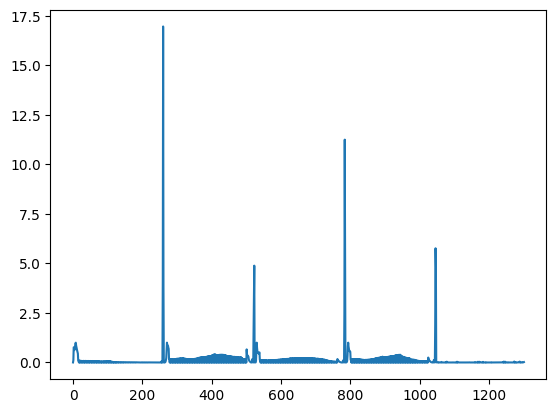

In [11]:
plt.plot(features[0])

### Train and Display Results

In [12]:

if options["plants"]: 
    X_train, X_test, y_train, y_test, yp_train, yp_test = train_test_split(features, labels, plant_labels, test_size=0.2, random_state=42)
    clf = LinearSVC(C=1.0, multi_class='ovr')
    clf.fit(X_train, yp_train)
    y_pred = clf.predict(X_test)
    print("LINEAR")
    print(classification_report(yp_test, y_pred))

    clf = RandomForestClassifier()
    clf.fit(X_train, yp_train)
    y_pred = clf.predict(X_test)
    print("FOREST")
    print(classification_report(yp_test, y_pred))
else:
    X_train, X_test, y_train, y_test, = train_test_split(features, labels, test_size=0.2, random_state=42)

In [13]:
clf = LinearSVC(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       706
           1       0.88      0.56      0.69       533

    accuracy                           0.78      1239
   macro avg       0.81      0.75      0.76      1239
weighted avg       0.80      0.78      0.77      1239



c:\Users\vasja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.95      0.88       706
           1       0.92      0.73      0.81       533

    accuracy                           0.86      1239
   macro avg       0.87      0.84      0.85      1239
weighted avg       0.87      0.86      0.85      1239



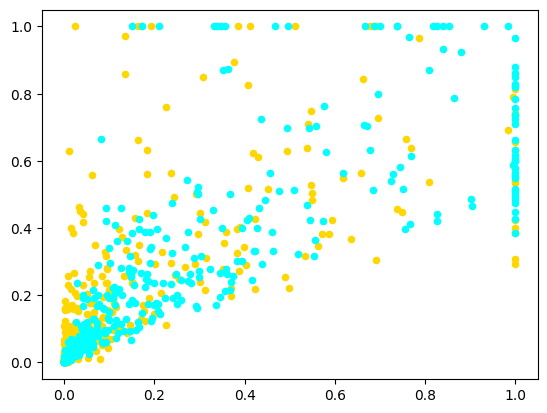

In [14]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
fig, ax = plt.subplots()
hits_0 = np.where(y_pred == 0)[0]
hits_1 = np.where(y_pred == 1)[0]
ax.scatter(X_test[hits_0, 0], X_test[hits_0, 1], c="gold", s=20, edgecolor=None, label='Class 0')
ax.scatter(X_test[hits_1, 0], X_test[hits_1, 1], c="cyan", s=20, edgecolor=None, label='Class 1')
plt.savefig("figs/tester.png")